In [1]:
# --- Install necessary libraries (only once per package) ---
%pip install matplotlib seaborn nltk textblob gensim wordcloud networkx spacy scikit-learn pyLDAvis

# --- Imports ---
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics & data manipulation
from scipy import stats


# NLP & text processing
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer

# Topic modeling & vectorization
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import sparse2full

# Text visualization
from wordcloud import WordCloud

# Network analysis
import networkx as nx

# Clustering & dimensionality reduction
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# LDA visualization
import pyLDAvis
import pyLDAvis.gensim_models

# Other utilities
from collections import Counter

# --- Download necessary NLTK resources ---
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mateu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mateu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Load and Preprocess Data**

In [2]:
# --- Step 1: Define file paths and dataset name ---
name = "PUBG"
input_path = f"Scrapping/{name}_cleaned_reviews.csv"
output_path = f"{name}_cleaned_processed_reviews.csv"

# --- Step 2: Load the dataset ---
data = pd.read_csv(input_path)

# --- Step 3: Clean 'Hours Played' and remove empty reviews ---
data['Hours Played'] = data['Hours Played'].replace(',', '', regex=True).astype(float)
data = data.dropna(subset=['Review'])

# --- Step 4: Define POS mapping function for lemmatizer ---
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# --- Step 5: Define preserved keywords and normalization dictionary ---
preserve_keywords = {'pubg', 'fps', 'fpp', 'tpp', 'mm', 'solo', 'squad'}

replacement_dict = {
    'cheating': 'cheat',
    'cheater': 'cheat',
    'cheated': 'cheat',
    'hacker': 'cheat',
    'hack': 'cheat',
    'aimbot': 'cheat',
    'wallhack': 'cheat',
    'battlegrounds': 'pubg',
}

# --- Step 6: Define the text preprocessing function ---
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()

    # Clean and tokenize
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip().lower()
    tokens = word_tokenize(text)

    # Define stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(['o', 'etc', 'would', 'could', 'us', 'the', 'to', 'of', 'in', 'it', 'and', 'this', 'that', 'for'])

    lemmatized = []
    for word, pos in pos_tag(tokens):
        if word in preserve_keywords:
            normalized = word
        elif word not in stop_words and len(word) > 1 and not word.isnumeric():
            base = lemmatizer.lemmatize(word, get_wordnet_pos(pos))
            normalized = replacement_dict.get(base, base)
        else:
            continue
        lemmatized.append(normalized)

    return ' '.join(lemmatized)

# --- Step 7: Apply preprocessing and save the output ---
data['Processed_Review'] = data['Review'].apply(preprocess_text)
data = data[data['Processed_Review'].str.strip() != ""]
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.to_csv(output_path, index=False)

# Preview the result
print(data.head())


     Game       Date                                             Review  \
0  578080 2020-06-25  After almost 1000 hours of playing, it's time ...   
1  578080 2020-01-17  After 2 years and 2,200 hours of gameplay, I w...   
2  578080 2020-04-26  3 years and 3,500 hours of gameplay and this g...   
3  578080 2021-04-22  AS OF 2024, Reporting system is shockers. TEAM...   
4  578080 2021-12-10       This game will be free from January 12 2022!   

   Hours Played   Recommendation  Helpful Votes  \
0        1326.7  Not Recommended           1320   
1        2808.4  Not Recommended           1216   
2        6186.4  Not Recommended            709   
3        2737.2  Not Recommended           3835   
4         358.6      Recommended           1884   

                                    Processed_Review  
0  almost hour play time voice thought own play p...  
1  year hour gameplay permanently ban pubg withou...  
2  year hour gameplay game still joke clunky glit...  
3  reporting system sh

# **Text Tokenization and Preparation**

In [3]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Step 8: Tokenize Processed Reviews
data['Tokenized_Review'] = data['Processed_Review'].apply(word_tokenize)

# Step 9: Build Vocabulary
def build_vocab_and_filter(data, min_word_freq=2):
    # Flatten all tokenized reviews to get all tokens
    all_tokens = [token for tokens in data['Tokenized_Review'] for token in tokens]
    vocab_counter = Counter(all_tokens)
    # Filter words by minimum frequency
    vocab = {word for word, count in vocab_counter.items() if count >= min_word_freq}
    return vocab

# Apply vocabulary filtering
min_word_freq = 2
vocab = build_vocab_and_filter(data, min_word_freq)

# Step 10: Filter Tokenized Reviews
data['Filtered_Review'] = data['Tokenized_Review'].apply(
    lambda tokens: [word for word in tokens if word in vocab]
)

# Step 11: Reconstruct Cleaned Documents
documents = data['Filtered_Review'].apply(lambda tokens: ' '.join(tokens))

# Step 12: Prepare Metadata
metadata = data.drop(columns=['Review', 'Processed_Review', 'Tokenized_Review', 'Filtered_Review'])

# Step 13: Save Outputs (Optional)
documents.to_csv(f'processed_{name}_documents.csv', index=False, header=['Documents'])
metadata.to_csv(f'processed_{name}_metadata.csv', index=False)

# Step 14: Display Samples
print("Sample Processed Documents:")
print(documents.head())

print("\nVocabulary Size:", len(vocab))
print("Sample Vocabulary:", list(vocab)[:10])

print("\nSample Metadata:")
print(metadata.head())


Sample Processed Documents:
0    almost hour play time voice thought own play p...
1    year hour gameplay permanently ban pubg withou...
2    year hour gameplay game still joke clunky glit...
3    reporting system team public thing radar cheat...
4                                    game free january
Name: Filtered_Review, dtype: object

Vocabulary Size: 3064
Sample Vocabulary: ['upcoming', 'competitively', 'didnt', 'anyways', 'shake', 'accidentally', 'esp', 'manipulate', 'publish', 'loose']

Sample Metadata:
     Game       Date  Hours Played   Recommendation  Helpful Votes
0  578080 2020-06-25        1326.7  Not Recommended           1320
1  578080 2020-01-17        2808.4  Not Recommended           1216
2  578080 2020-04-26        6186.4  Not Recommended            709
3  578080 2021-04-22        2737.2  Not Recommended           3835
4  578080 2021-12-10         358.6      Recommended           1884


# **Sentiment Analysis**
Building World Clouds
Extracted key terms for each topic using labelTopics.
Visualized top words.
without date included

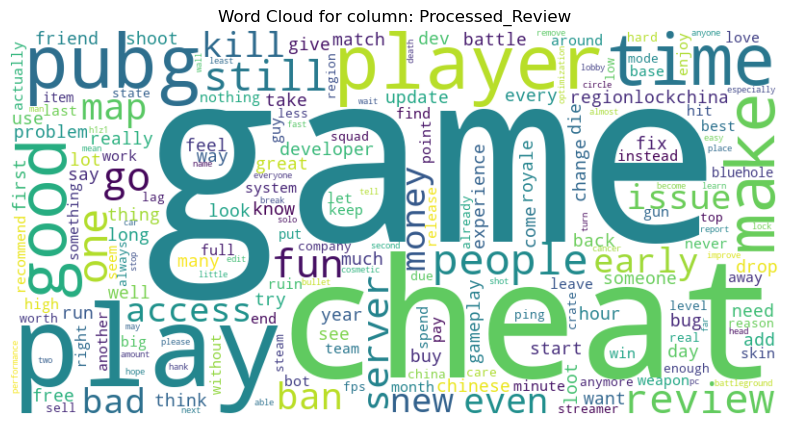

In [4]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data = pd.read_csv('PUBG_cleaned_processed_reviews.csv')# Select the column with text (e.g., 'review_text')
text_column = 'Processed_Review'
text_data = data[text_column].dropna().astype(str).str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    collocations=False  # Avoid duplicate phrases
).generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud for column: {text_column}')
plt.show()


PUBG becomes free to play

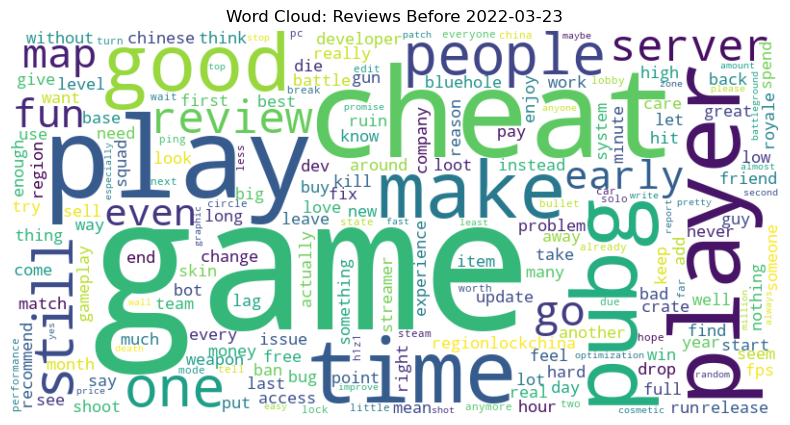

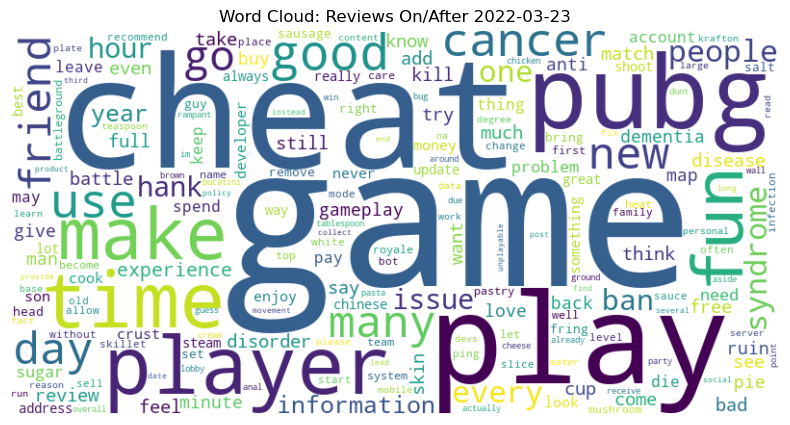

In [5]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load data

date = '2022-03-23'
# Convert 'date' column to datetime (adjust the column name if needed)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Split data into two periods
date_split = pd.Timestamp(date)
before_df = data[data['Date'] < date_split]
after_df = data[data['Date'] >= date_split]

text_column = 'Processed_Review'

def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=200,
        collocations=False
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Prepare text for each period
text_before = before_df[text_column].dropna().astype(str).str.cat(sep=' ')
text_after = after_df[text_column].dropna().astype(str).str.cat(sep=' ')

# Generate and show word clouds
generate_wordcloud(text_before, f'Word Cloud: Reviews Before {date}')
generate_wordcloud(text_after, f'Word Cloud: Reviews On/After {date}')


# **Word Frequencies**
without date included

       word  frequency
17     game       2006
46    cheat        739
2      play        575
42      get        521
106  player        386
7      pubg        363
19     like        342
3      time        334
95     make        298
12     good        294
186  people        244
52      one        236
77    still        221
50   review        220
65       go        212
519     fun        206
759  server        198
49      ban        183
20      map        183
93     even        177


C:\Users\mateu\AppData\Local\Temp\ipykernel_43060\2262072920.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data=freq_df, palette='viridis')


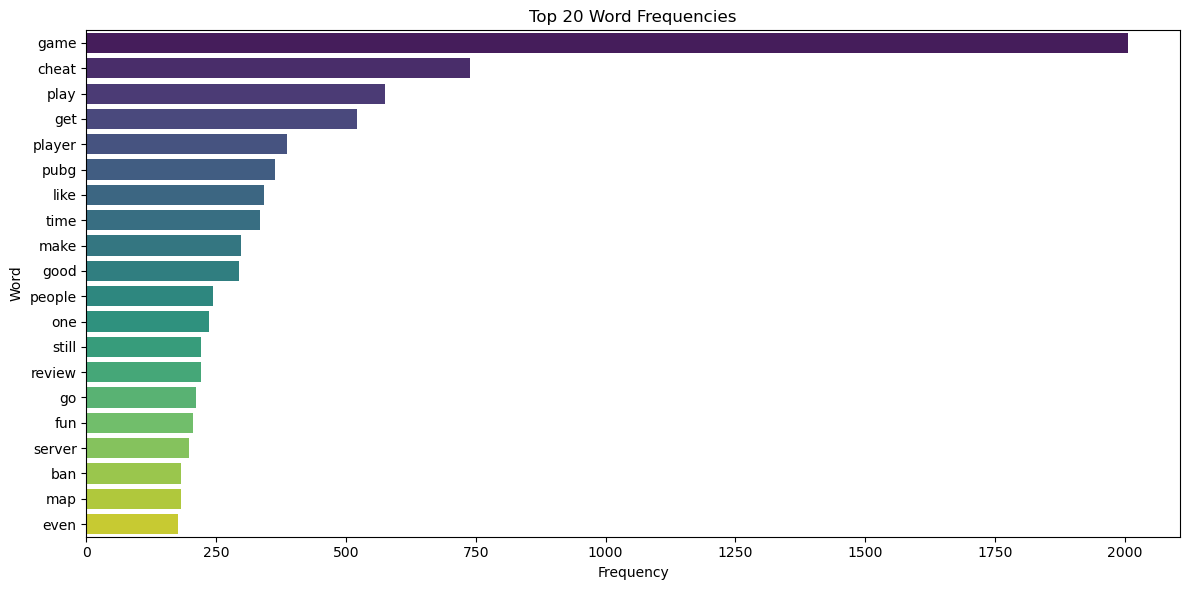

In [6]:
import pandas as pd
from collections import Counter
import re

# Select the column with text (e.g., 'review_text')
text_column = 'Processed_Review'  # Change to your actual column name
# Combine all text into one large string
all_text = ' '.join(data[text_column].dropna().astype(str).tolist())

# Basic cleaning: remove punctuation and make lowercase
cleaned_text = re.sub(r'[^\w\s]', '', all_text.lower())

# Tokenize
words = cleaned_text.split()

# Count word frequencies
word_freq = Counter(words)

# Convert to DataFrame and show top 20
freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])
freq_df = freq_df.sort_values(by='frequency', ascending=False)

print(freq_df.head(20))
freq_df = freq_df.head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', data=freq_df, palette='viridis')
plt.title('Top 20 Word Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()


Before and after update

C:\Users\mateu\AppData\Local\Temp\ipykernel_43060\449507687.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data=freq_df, palette='viridis')


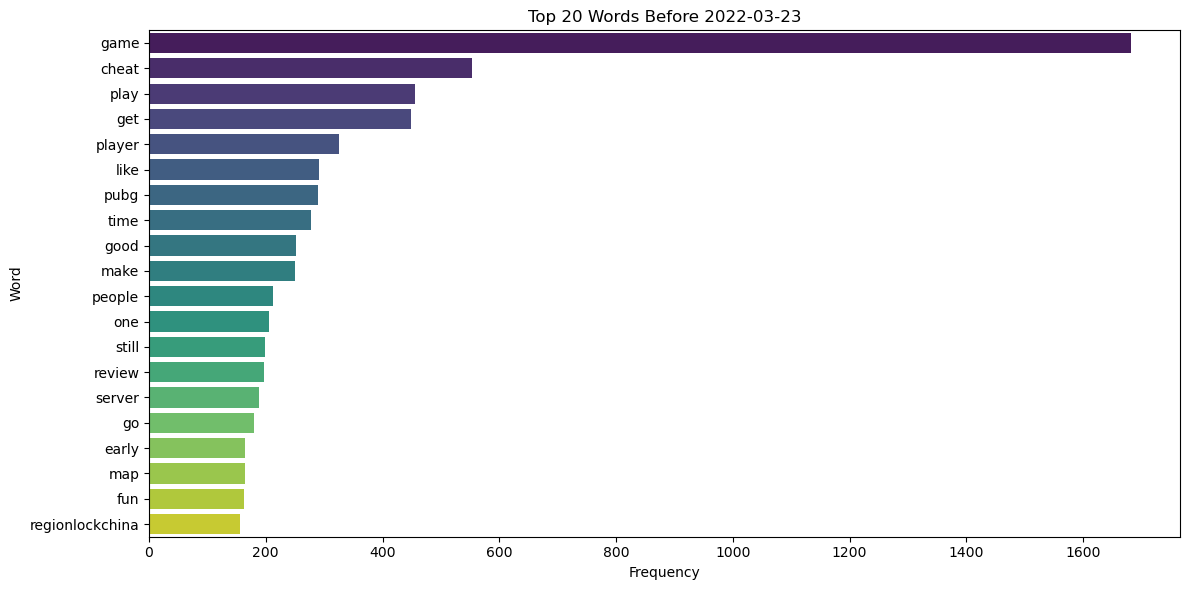

C:\Users\mateu\AppData\Local\Temp\ipykernel_43060\449507687.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data=freq_df, palette='viridis')


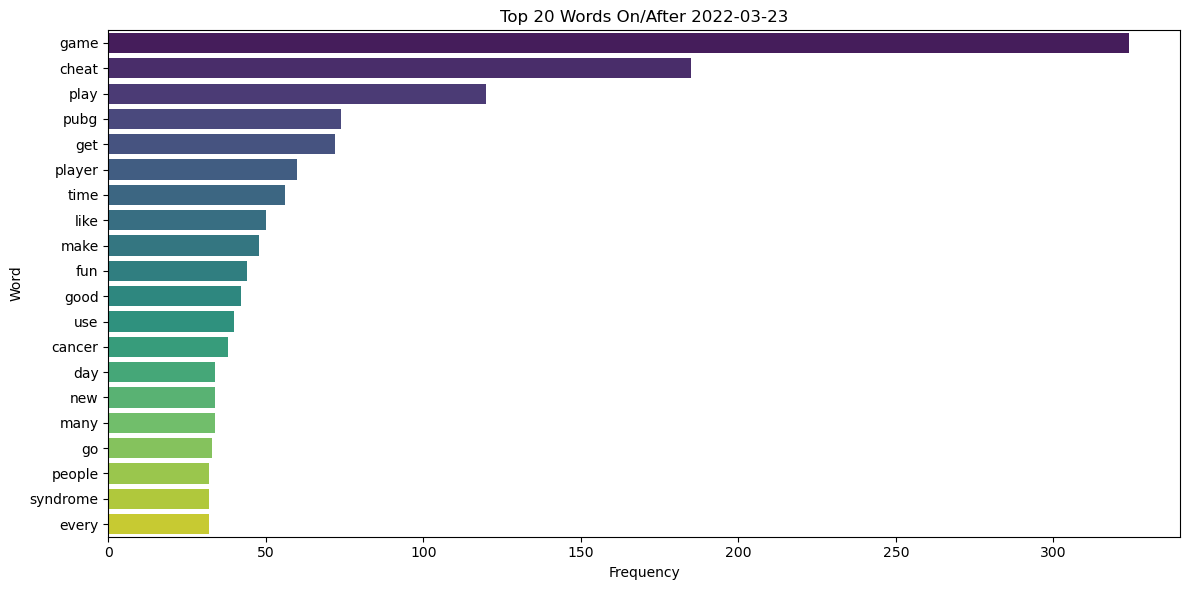

In [7]:
import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns


# Convert date column to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # replace 'date' with your date column name

# Define date cutoff
cutoff_date = pd.Timestamp('2022-03-23')

# Function to get top word frequencies and plot
def plot_top_words(df, text_col, title):
    all_text = ' '.join(df[text_col].dropna().astype(str).tolist())
    cleaned_text = re.sub(r'[^\w\s]', '', all_text.lower())
    words = cleaned_text.split()
    word_freq = Counter(words)
    freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])
    freq_df = freq_df.sort_values(by='frequency', ascending=False).head(20)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='frequency', y='word', data=freq_df, palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

# Filter data by date
before_df = data[data['Date'] < cutoff_date]
after_df = data[data['Date'] >= cutoff_date]

# Column with text
text_column = 'Processed_Review'  # Change if needed

# Plot word frequencies for each period
plot_top_words(before_df, text_column, f'Top 20 Words Before {date}')
plot_top_words(after_df, text_column, f'Top 20 Words On/After {date}')



# **Step 5: Sentiment Score and Sentiment Category Distribution**

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mateu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


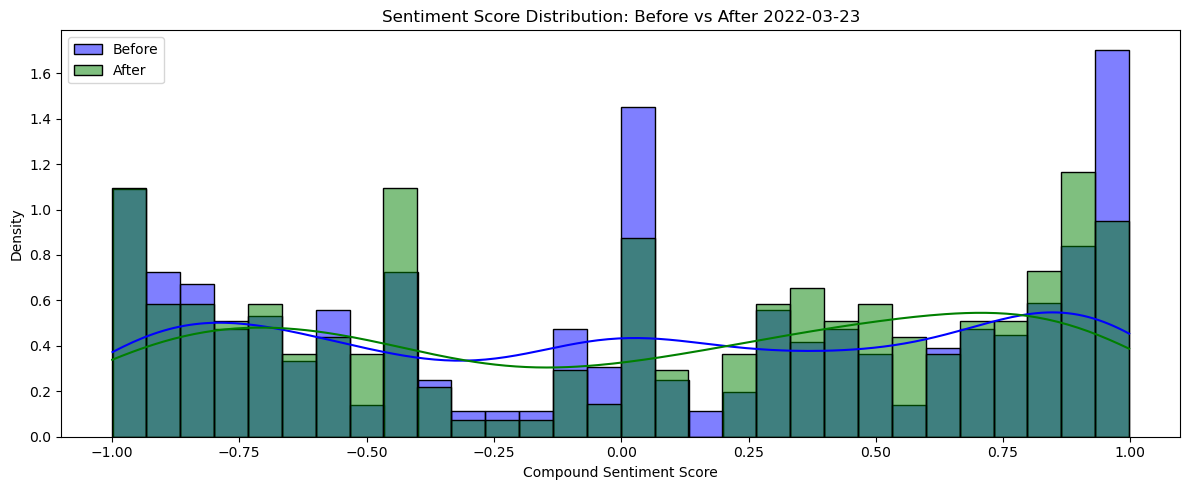

C:\Users\mateu\AppData\Local\Temp\ipykernel_43060\1606044108.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=before_df, ax=axs[0], palette='Blues')
C:\Users\mateu\AppData\Local\Temp\ipykernel_43060\1606044108.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=after_df, ax=axs[1], palette='Greens')


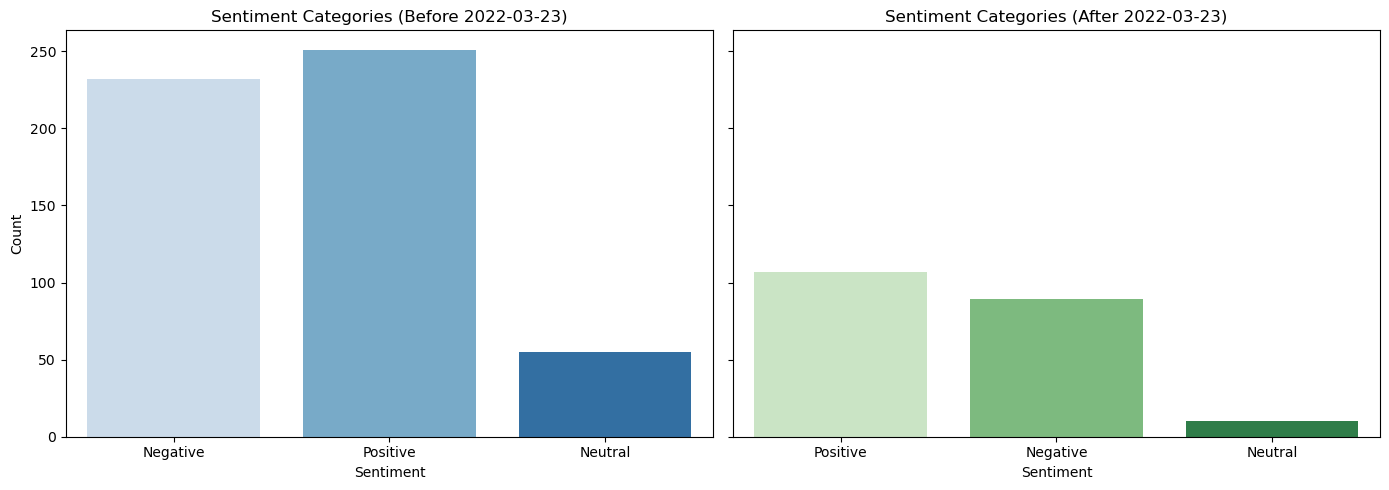

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER if not done already
nltk.download('vader_lexicon')

# Ensure date is datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Drop missing reviews
data = data.dropna(subset=['Processed_Review'])

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
data['sentiment_score'] = data['Processed_Review'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# Categorize into sentiment classes
def get_sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment_category'] = data['sentiment_score'].apply(get_sentiment_category)

# Split before and after
cutoff = pd.Timestamp(date)
before_df = data[data['Date'] < cutoff]
after_df = data[data['Date'] >= cutoff]

# ---------- PLOT 1: Sentiment Score Distribution ----------
plt.figure(figsize=(12, 5))
sns.histplot(before_df['sentiment_score'], color='blue', kde=True, label='Before', bins=30, stat='density')
sns.histplot(after_df['sentiment_score'], color='green', kde=True, label='After', bins=30, stat='density')
plt.title(f'Sentiment Score Distribution: Before vs After {date}')
plt.xlabel('Compound Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()

# ---------- PLOT 2: Sentiment Category Counts ----------
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.countplot(x='sentiment_category', data=before_df, ax=axs[0], palette='Blues')
axs[0].set_title(f'Sentiment Categories (Before {date})')
axs[0].set_xlabel('Sentiment')
axs[0].set_ylabel('Count')

sns.countplot(x='sentiment_category', data=after_df, ax=axs[1], palette='Greens')
axs[1].set_title(f'Sentiment Categories (After {date})')
axs[1].set_xlabel('Sentiment')

plt.tight_layout()
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mateu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


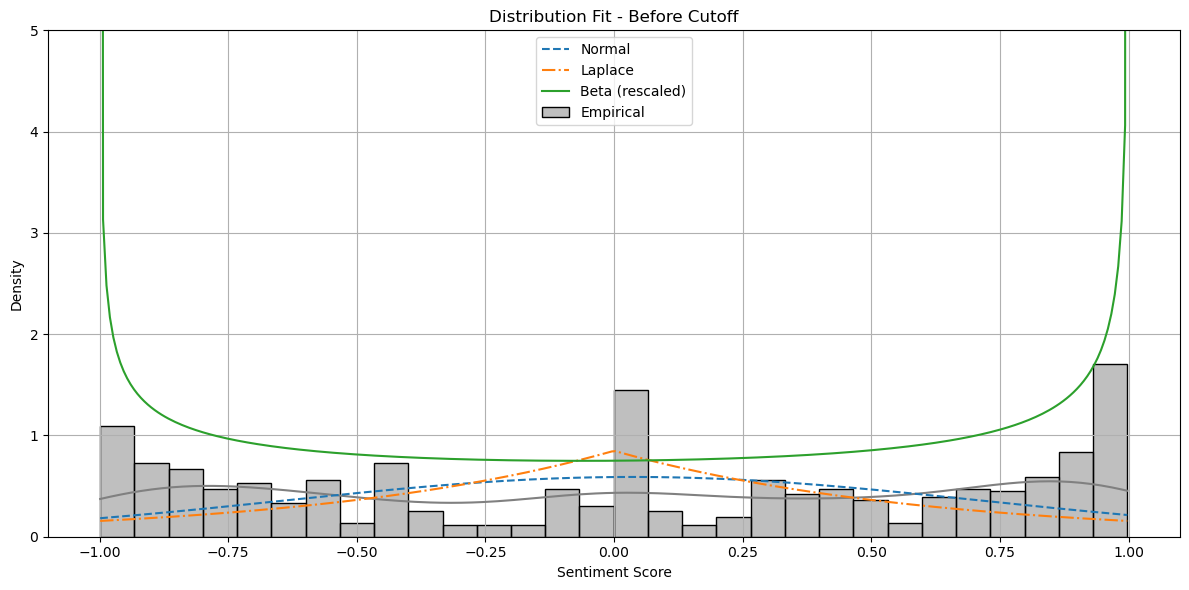

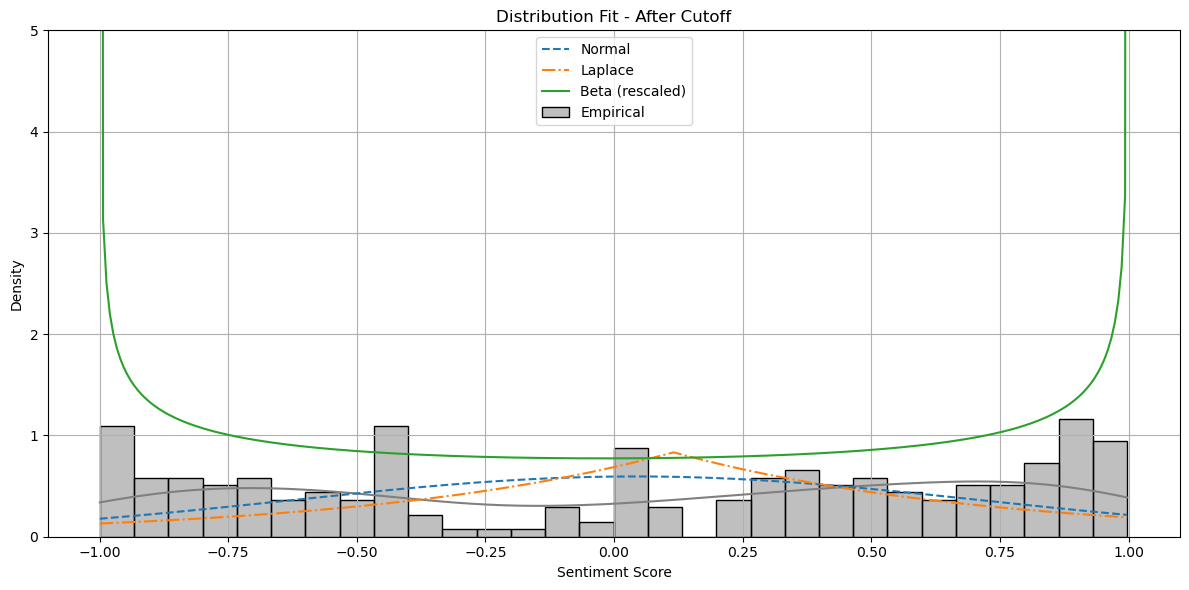

In [9]:
# --- Download necessary NLTK resources ---
nltk.download('vader_lexicon')

# --- Load data ---
data = pd.read_csv("PUBG_cleaned_processed_reviews.csv")
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Processed_Review'])

# --- Compute sentiment scores using VADER ---
sia = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['Processed_Review'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# --- Categorize sentiment ---
def get_sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment_category'] = data['sentiment_score'].apply(get_sentiment_category)

# --- Set the cutoff date ---
cutoff = pd.Timestamp("2022-03-23")  # change as needed
before_df = data[data['Date'] < cutoff]
after_df = data[data['Date'] >= cutoff]

# --- Function to compare distributions ---
def compare_distributions(sample, title):
    plt.figure(figsize=(12, 6))
    
    # Plot histogram and KDE
    sns.histplot(sample, kde=True, stat='density', bins=30, label='Empirical', color='gray', edgecolor='black')

    # Fit and plot Normal distribution
    mu, std = sample.mean(), sample.std()
    x = np.linspace(sample.min(), sample.max(), 300)
    plt.plot(x, stats.norm.pdf(x, mu, std), label='Normal', linestyle='--')

    # Fit and plot Laplace distribution
    loc, scale = stats.laplace.fit(sample)
    plt.plot(x, stats.laplace.pdf(x, loc, scale), label='Laplace', linestyle='-.')

    # Fit and plot Beta distribution (rescaled from [-1, 1] to (0, 1))
    sample_beta = (sample + 1) / 2
    sample_beta = np.clip(sample_beta, 1e-6, 1 - 1e-6)  # avoid 0 and 1
    a_beta, b_beta, _, _ = stats.beta.fit(sample_beta, floc=0, fscale=1)
    x_beta = np.linspace(1e-6, 1 - 1e-6, 300)
    plt.plot((x_beta * 2 - 1), stats.beta.pdf(x_beta, a_beta, b_beta), label='Beta (rescaled)', linestyle='-')

   # Final formatting
    plt.title(f"Distribution Fit - {title}")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Density")
    plt.ylim(0, 5)  # <-- key fix for visibility
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Compare for both groups ---
compare_distributions(before_df['sentiment_score'], title="Before Cutoff")
compare_distributions(after_df['sentiment_score'], title="After Cutoff")


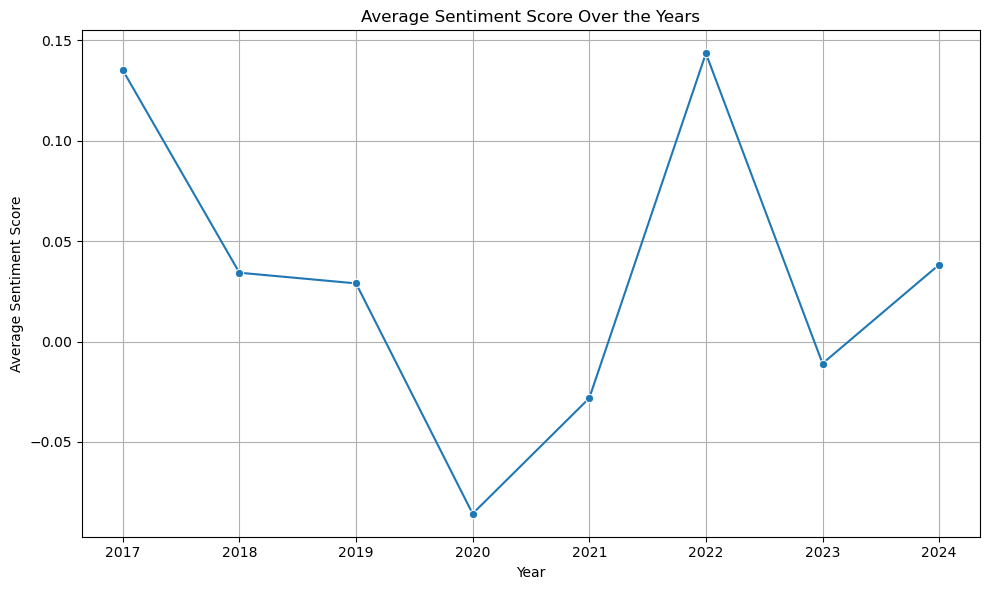

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Extract year from Date ---
data['Year'] = data['Date'].dt.year

# --- Aggregate: mean sentiment per year ---
yearly_sentiment = data.groupby('Year')['sentiment_score'].mean().reset_index()


# --- Plot ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_sentiment, x='Year', y='sentiment_score', marker='o')
plt.title('Average Sentiment Score Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()


# **Step Sentiment vs user recommendation**
check if the sentiment alligns with whether the user recommendet the game or not.
Reccomended column is 2 variable one sentiment is a 3 variable one so we should not use a barplot like this one we should use a box plot to analyze sentiment score distribution by recommendation first, maybe that way we can assume that "Recommended" value can be also interpreted as neutral. Making sentiment score a 2 categorical variable.

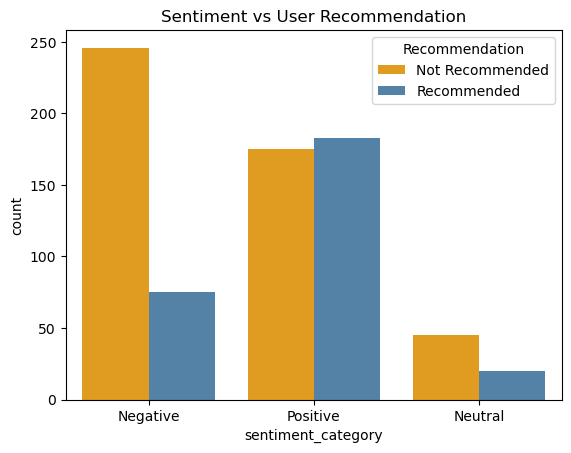

Number of NaN values in 'Recommendation': 0

Unique values and their counts in 'Recommendation':
Recommendation
Not Recommended    466
Recommended        278
Name: count, dtype: int64


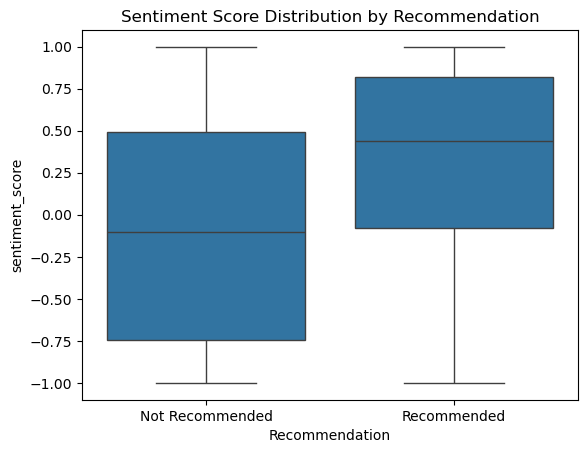

In [15]:
# Compare VADER sentiment to user's recommendation
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment_category', hue='Recommendation', data=data, 
              palette={'Recommended': 'steelblue', 'Not Recommended': 'orange'})
plt.title('Sentiment vs User Recommendation')
plt.show()


# Check for NaN values
nan_count = data['Recommendation'].isna().sum()
print(f"Number of NaN values in 'Recommendation': {nan_count}")

# Show unique values and their counts
print("\nUnique values and their counts in 'Recommendation':")
print(data['Recommendation'].value_counts(dropna=False))  # includes NaNs

pd.crosstab(data['sentiment_category'], data['Recommendation'])
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=data, x='Recommendation', y='sentiment_score')
plt.title("Sentiment Score Distribution by Recommendation")
plt.show()


## **Analysis of Interactions Between Sentiment Score, Recommendation, Hours Played, and Helpful Votes**

This analysis leverages metadata such as "Hours Played" and "Helpful Votes" to enhance sentiment analysis and recommendation evaluation by providing contextual information to the review content.

### Objective of the Analysis

The goal is to investigate the interactions between the following variables:
- Sentiment Score (text sentiment)
- Recommendation (game recommendation: positive/negative)
- Hours Played (amount of time spent in the game)
- Helpful Votes (number of users who found the review helpful)

### Rationale for Using Metadata

- "Hours Played" serves as an indicator of user engagement. A high number of hours combined with negative sentiment may suggest valid, constructive criticism.
- "Helpful Votes" reflect the perceived value or quality of a review. A high number of helpful votes may indicate a more influential or trusted opinion.

### Scope of the Analysis

The following research questions will be addressed:

- Do highly engaged users (with many hours played) express more polarized sentiments?
- Are reviews with few helpful votes more neutral or noisy in nature?
- Do "Not Recommended" reviews with a high number of helpful votes form separate clusters compared to other reviews?


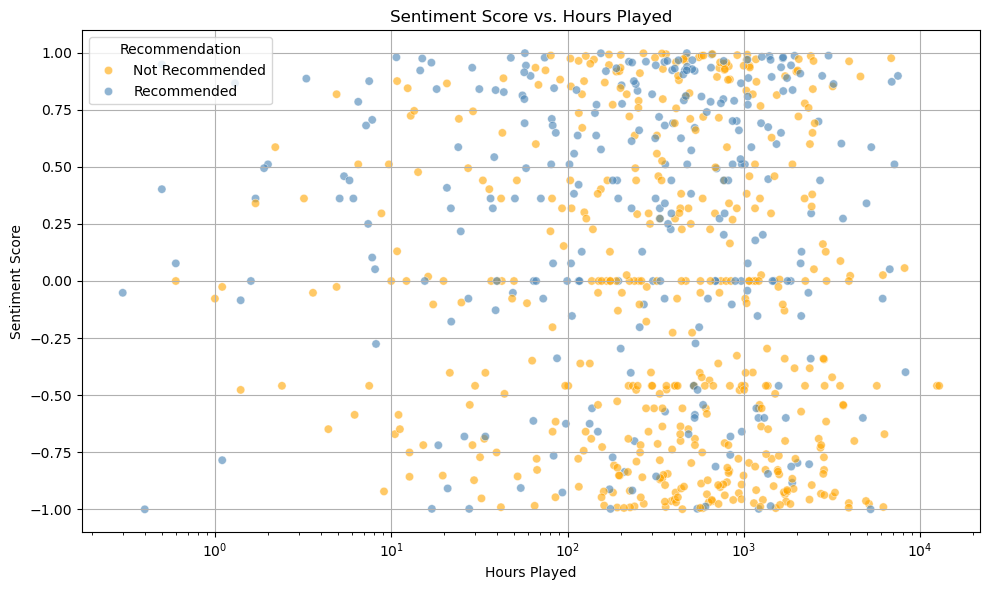

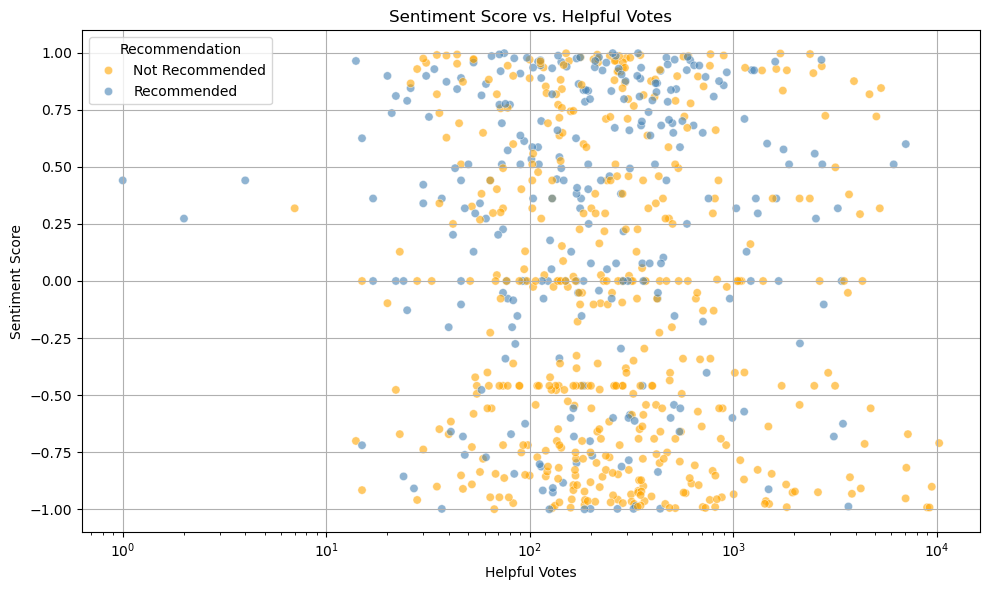

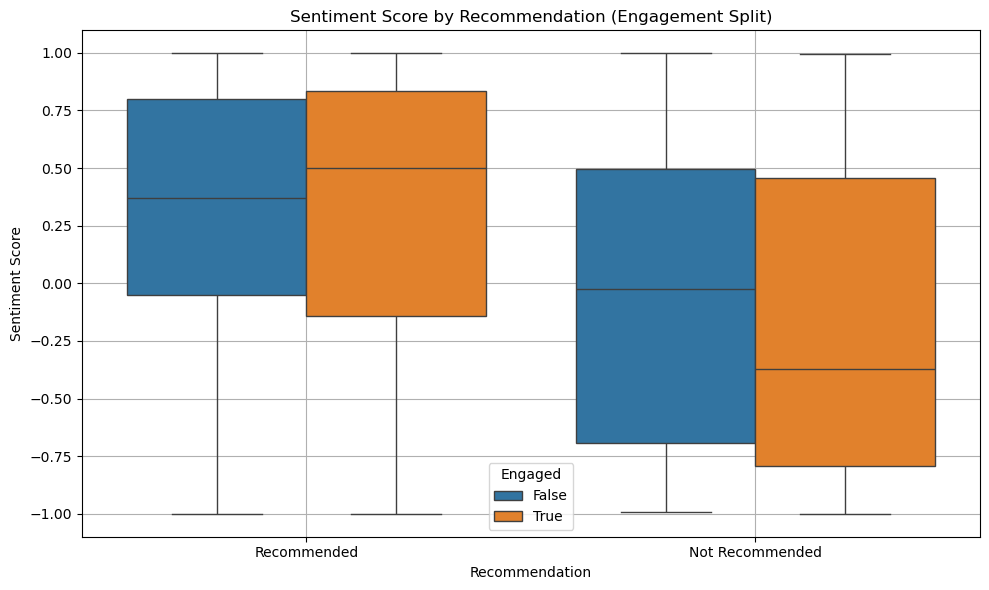

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = data.copy()

# Ensure correct data types
df['Date'] = pd.to_datetime(df['Date'])
df['Hours Played'] = pd.to_numeric(df['Hours Played'], errors='coerce')
df['Helpful Votes'] = pd.to_numeric(df['Helpful Votes'], errors='coerce')
df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')  # assuming it already exists

# Drop rows with missing values in critical columns
df_clean = df.dropna(subset=['sentiment_score', 'Hours Played', 'Helpful Votes', 'Recommendation'])

# Define color palette (reversed)
palette = {'Recommended': 'steelblue', 'Not Recommended': 'orange'}

# 1. Sentiment vs Hours Played
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean,
    x='Hours Played',
    y='sentiment_score',
    hue='Recommendation',
    palette=palette,
    alpha=0.6
)
plt.title('Sentiment Score vs. Hours Played')
plt.xlabel('Hours Played')
plt.ylabel('Sentiment Score')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Sentiment vs Helpful Votes
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean,
    x='Helpful Votes',
    y='sentiment_score',
    hue='Recommendation',
    palette=palette,
    alpha=0.6
)
plt.title('Sentiment Score vs. Helpful Votes')
plt.xlabel('Helpful Votes')
plt.ylabel('Sentiment Score')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Boxplot: Sentiment by Recommendation and Engagement
df_clean['Engaged'] = df_clean['Hours Played'] > df_clean['Hours Played'].median()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_clean,
    x='Recommendation',
    y='sentiment_score',
    hue='Engaged',
    order=['Recommended', 'Not Recommended']  # enforce desired order
)
plt.title('Sentiment Score by Recommendation (Engagement Split)')
plt.xlabel('Recommendation')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()


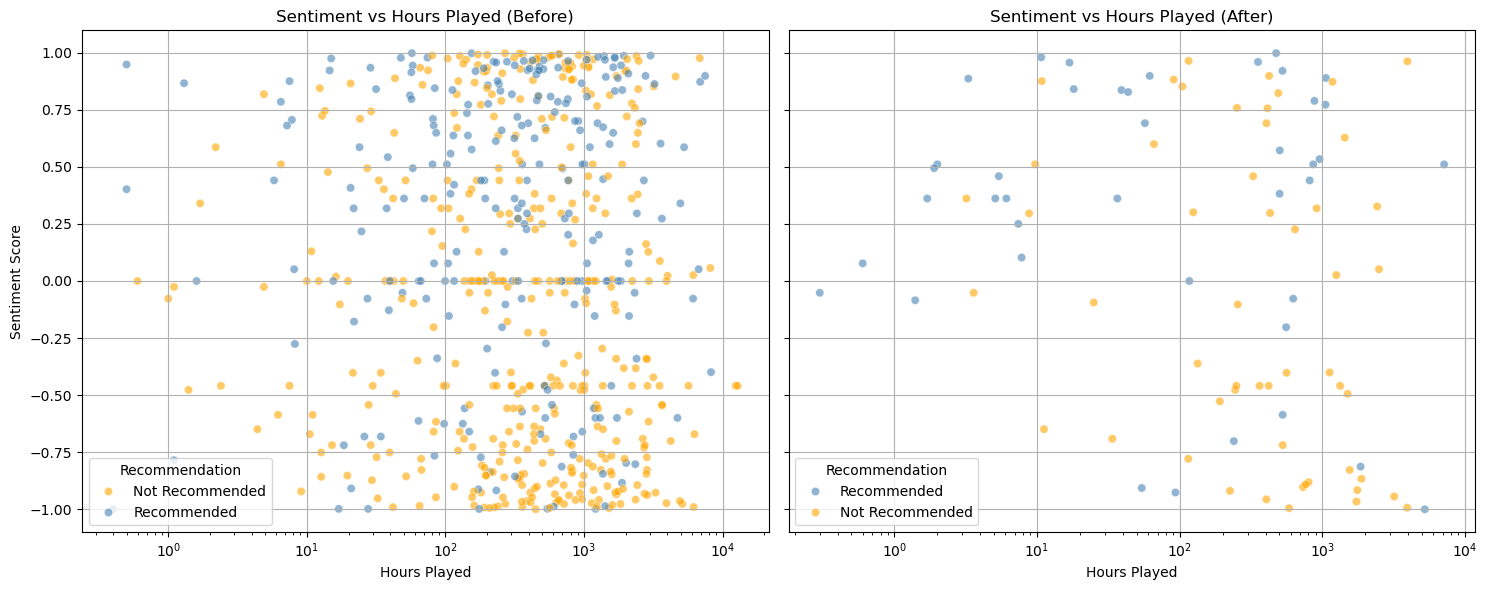

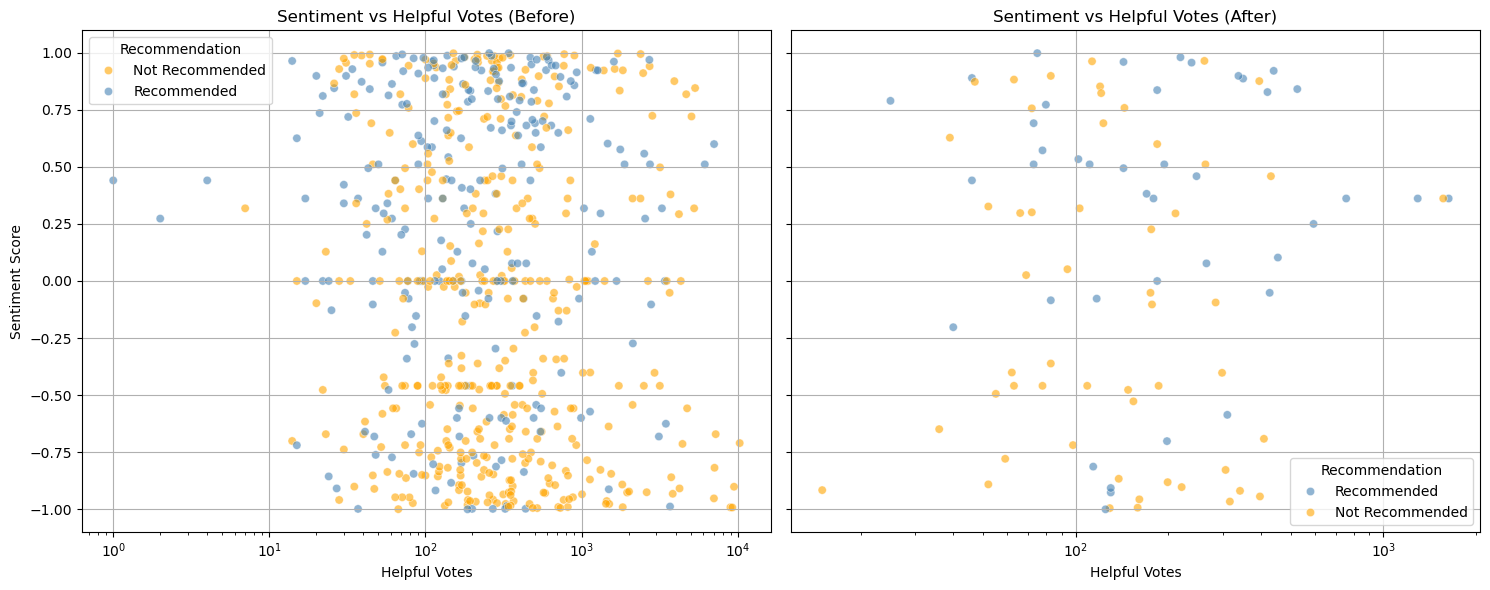

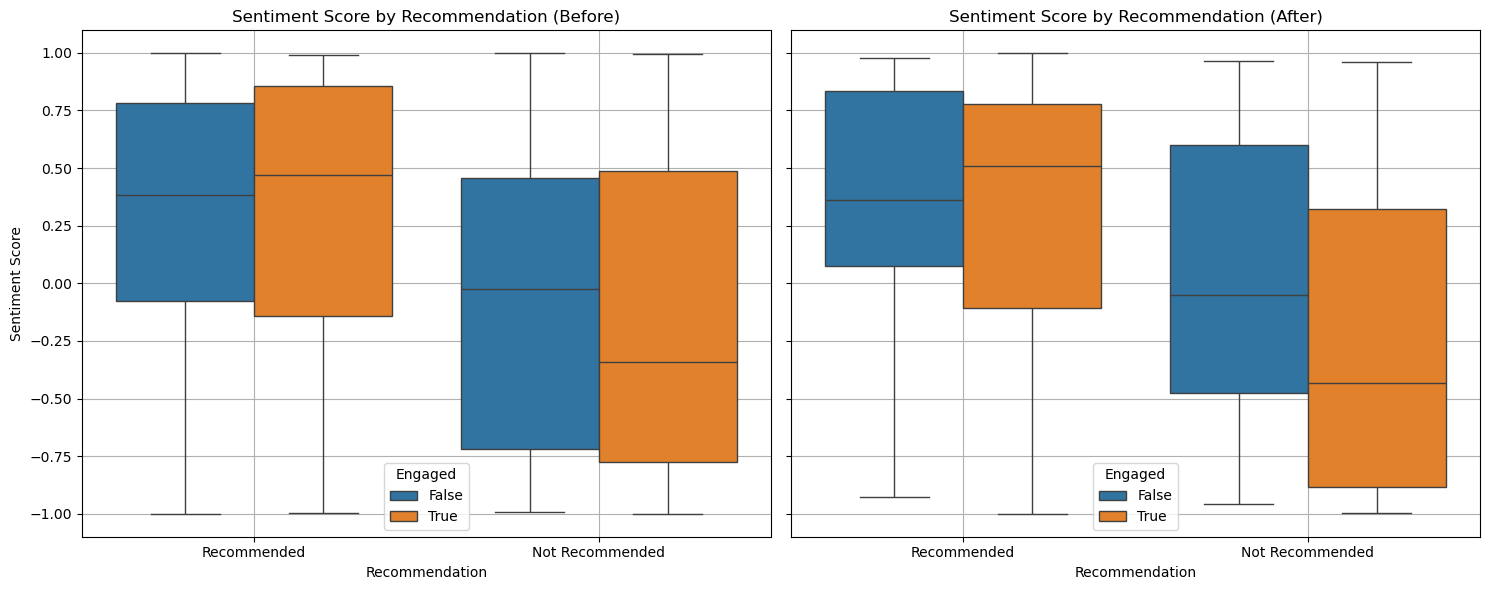

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare data ---
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df['Hours Played'] = pd.to_numeric(df['Hours Played'], errors='coerce')
df['Helpful Votes'] = pd.to_numeric(df['Helpful Votes'], errors='coerce')
df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')

# --- Define cutoff date ---
cutoff = pd.Timestamp("2023-09-29")
df['Period'] = df['Date'].apply(lambda d: 'Before' if d < cutoff else 'After')

# --- Clean data ---
df_clean = df.dropna(subset=['sentiment_score', 'Hours Played', 'Helpful Votes', 'Recommendation'])
df_clean['Engaged'] = df_clean['Hours Played'] > df_clean['Hours Played'].median()

# --- PLOT 1: Sentiment vs Hours Played ---
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
for i, period in enumerate(['Before', 'After']):
    subset = df_clean[df_clean['Period'] == period]
    sns.scatterplot(
        data=subset,
        x='Hours Played',
        y='sentiment_score',
        hue='Recommendation',
        palette={'Recommended': 'steelblue', 'Not Recommended': 'orange'},  # swapped colors
        alpha=0.6,
        ax=axs[i]
    )
    axs[i].set_xscale('log')
    axs[i].set_title(f'Sentiment vs Hours Played ({period})')
    axs[i].set_xlabel('Hours Played')
    axs[i].set_ylabel('Sentiment Score')
    axs[i].grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 2: Sentiment vs Helpful Votes ---
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
for i, period in enumerate(['Before', 'After']):
    subset = df_clean[df_clean['Period'] == period]
    sns.scatterplot(
        data=subset,
        x='Helpful Votes',
        y='sentiment_score',
        hue='Recommendation',
        palette={'Recommended': 'steelblue', 'Not Recommended': 'orange'},  # swapped colors
        alpha=0.6,
        ax=axs[i]
    )
    axs[i].set_xscale('log')
    axs[i].set_title(f'Sentiment vs Helpful Votes ({period})')
    axs[i].set_xlabel('Helpful Votes')
    axs[i].set_ylabel('Sentiment Score')
    axs[i].grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 3: Boxplot by Recommendation & Engagement ---
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
for i, period in enumerate(['Before', 'After']):
    subset = df_clean[df_clean['Period'] == period]
    sns.boxplot(
        data=subset,
        x='Recommendation',
        y='sentiment_score',
        hue='Engaged',
        order=['Recommended', 'Not Recommended'],  # reordered boxplot x-axis
        ax=axs[i]
    )
    axs[i].set_title(f'Sentiment Score by Recommendation ({period})')
    axs[i].set_xlabel('Recommendation')
    axs[i].set_ylabel('Sentiment Score')
    axs[i].grid(True)
plt.tight_layout()
plt.show()


<Axes: xlabel='sentiment_category', ylabel='Hours Played'>

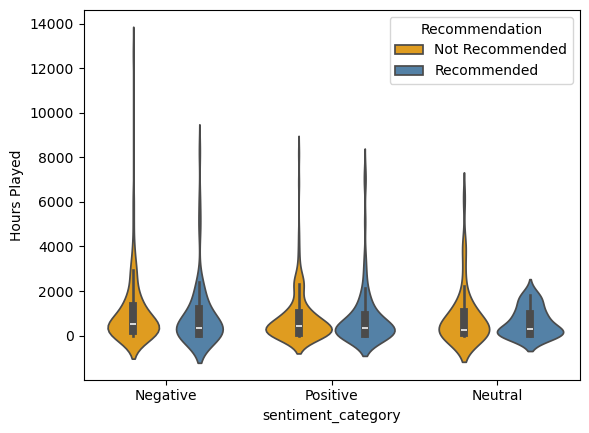

In [20]:
sns.violinplot(
    data=df_clean,
    x='sentiment_category',
    y='Hours Played',
    hue='Recommendation',
    palette={'Recommended': 'steelblue', 'Not Recommended': 'orange'}
)


In [18]:
# --- Subset data into Before and After groups ---
before = df_clean[df_clean['Period'] == 'Before']
after = df_clean[df_clean['Period'] == 'After']

# --- Calculate Pearson correlation coefficients ---
correlations = {
    "Sentiment vs Hours Played": {
        "Before": before['sentiment_score'].corr(before['Hours Played']),
        "After": after['sentiment_score'].corr(after['Hours Played'])
    },
    "Sentiment vs Helpful Votes": {
        "Before": before['sentiment_score'].corr(before['Helpful Votes']),
        "After": after['sentiment_score'].corr(after['Helpful Votes'])
    }
}

# --- Display the results ---
for description, values in correlations.items():
    print(f"\n{description}:")
    print(f"  Before: {values['Before']:.4f}")
    print(f"  After : {values['After']:.4f}")



Sentiment vs Hours Played:
  Before: -0.0603
  After : -0.2005

Sentiment vs Helpful Votes:
  Before: -0.0955
  After : 0.0930
